In [1]:
import warnings
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## Data

In [2]:
print("Load transaction data")
%time df = pd.read_csv('data/train_data.csv', index_col=0)
print("{0} transaction data loaded, containing {1} fraudulent transactions".format(len(df),df['is_fraud'].sum()))

Load transaction data
CPU times: user 16.4 s, sys: 2.95 s, total: 19.3 s
Wall time: 21.6 s
1296675 transaction data loaded, containing 7506 fraudulent transactions


In [3]:
# df.info()

### Train-Validation Split

Before splitting, let's a sanity check on if a credict card is going to be compromised once being falgged. This is important for splitting since if it would be compromised, we should remove all the known compromised card number from the validation set.

In [3]:
# Ensure the 'trans_date_trans_time' and 'first_fraud_date' columns are in datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Identify the first fraud transaction for each cc_num
first_fraud_transactions = df[df['is_fraud'] == 1].groupby('cc_num')['trans_date_trans_time'].min().reset_index()
first_fraud_transactions.columns = ['cc_num', 'first_fraud_date']

# Merge the first fraud transaction date back to the original dataframe
df_checkcompromised_card = df.merge(first_fraud_transactions, on='cc_num', how='left')

# Ensure the 'first_fraud_date' column is in datetime format
df_checkcompromised_card['first_fraud_date'] = pd.to_datetime(df_checkcompromised_card['first_fraud_date'])
# Fill NaT values in 'first_fraud_date' with a date far in the future to avoid comparison issues
df_checkcompromised_card['first_fraud_date'].fillna(pd.Timestamp.max, inplace=True)
# Check for non-fraud transactions that occur after the first fraud transaction for the same cc_num with a delay of one month
future_non_fraud_transactions = df_checkcompromised_card[(df_checkcompromised_card['is_fraud'] == 0) & (df_checkcompromised_card['trans_date_trans_time'] > (df_checkcompromised_card['first_fraud_date'] + pd.DateOffset(days=3)))]
non_compromised_card_numbers = future_non_fraud_transactions['cc_num'].unique()

print("At least {} percent card not compromised after 3 days of being flagged fraud".format(len(non_compromised_card_numbers)/df['cc_num'].nunique()))

At least 0.9175991861648016 percent card not compromised after 3 days of being flagged fraud


Now we can split the data into train and validation sets. The goal of our model is to be able to predict potential fraudulent transactions given new data from the **future**, thus it's very important that during training, there is no 'data leakage'. The transaction times in the validation set should typically occur after those in the training set. Additionally, to mimic real-world fraud detection, the label indicating whether a transaction is fraudulent is often only available after a customer complaint or a fraud investigation. This means we need to account for a delay period. Therefore, in a realistic scenario, data available for training a model and making predictions for a given day would be from transactions occurring before that day counting the delay period. In addition, to make our prediction more robust and less prone to data distribution shifts, we use a rolling window on the time axis for training, delaying and validation. This way, we also made better usage of the historical data given. Below is an illustration on how we split our data.

<p align="center">
    <img src="out/data_splitting.png" width=1000>
</p>

In [4]:
from utils.data import create_data_splits
# the create_data_splits function will return a dictionary containing the train and validation sets in batches
splits =  create_data_splits(df, 'trans_date_trans_time', freq='30D', rolling_window=90, gap=31, val_duration=90) #in theroy, val_duration should be the same as test set time length

### Feature Selection

In [5]:
drop_col = ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 
'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'unix_time', 
'job_category', 'trans_date', 'trans_num', 'is_fraud']

In [6]:
input_features = [col for col in df.columns if col not in drop_col]
target_feature = ['is_fraud']

alternatively, one could fit a simple tree-based classifier and calculated feature importance. Combining with domain knowlwdge and the results from feature importance, one can get a more coherent feature list. However, as an preliminary step, I decided to use all columns with numerical values and drop columns that are clearly irrelevant (e.g., indices, cc_num, names) or redundant (e.g., date components already captured in other features).

In [17]:
# from sklearn.classifier import RandomForestClassifier
# X = df[input_feature]
# y = df['is_fraud']
# clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
# clf.fit(X, y)
# feature_importances = clf.feature_importances_
# feature_importances = pd.DataFrame({'feature': input_feature, 'importance': feature_importances})
# feature_importances = feature_importances.sort_values('importance', ascending=False)[:20]

## Models

Before diving in, there are several issues to be addressed:
- **Target Imbalance**: we need to deal with very sparse transaction data being flagged as fraud (by sparse, here we have around 0.5% in training data)
- **Data Distribution shifts**: we need to take into account complexity and performance, decide on metrics and retrain window as frauding schemes changes quickly over time and it's a very dynamic activity.
- **Explainability**: if we need to explain to clients and have reasoning on why we would want to flag a certain transactions being predicted as fraud

### Evaluation Metrics

Fraud detection is inherently a cost-sensitive challenge. Missing a fraudulent transaction incurs significant costs, including the transaction amount to be reimbursed, potential subsequent fraudulent activities, customer service expenses, and damage to the company's reputation. On the other hand, false alerts on legitimate transactions generally involve lower costs, such as verifying the transaction with the customer. However, in real-time scenarios, false alerts can also lead to customer inconvenience due to blocked legitimate payments. The overall cost should also include the time taken by the detection system to react. The shorter the reaction time, the larger the number of frauds that can be prevented. Taking all in account, the evaluation metrics that I use are:

- **classification wise**:
1. F1 score
2. Roc_auc
3. Average Precision
4. Top K Precision: 
5. Confusion Matrix

- **impact wise**: fraud losses (amount of money loss due to FN predictions) 

***
- The formula for F1 Score is:

$$
\small{F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}}
$$

where:

- $\small{Precision = \frac{TP}{TP + FP}}$
- $\small{Recall = \frac{TP}{TP + FN}}$

$TP$ is True Positives, $FP$ is False Positives, and $FN$ is False Negatives.
The formula for ROC AUC (Receiver Operating Characteristic Area Under the Curve) is:

$$
\small{ROC\_AUC = \int_0^1 TPR(FPR) \, dFPR}
$$

where  $TPR$  is the True Positive Rate and $FPR$ is the False Positive Rate.  The integral is taken over the range of FPR from 0 to 1. 
***
- The formula for Average Precision (AP) is:

$$
\small{AP = \sum_{n=1}^N (R_n - R_{n-1}) P_n}
$$

where $P_n$ and $R_n$ are the precision and recall at the nth threshold, and $N$ is the total number of thresholds. $R_0$ is defined as 0.
***
- Top K Precision:
The TKP can be computed by ranking all fraud probabilities by decreasing order, and computing the precision for the top K ranked transactions per and average over the validation/test time window.


In [ ]:
def precision_top_k_day(df_day):
    top_k = df_day['is_fraud'].sum()
    
    # Order transactions by decreasing probabilities of frauds
    df_day = df_day.sort_values(by="predictions", ascending=False).reset_index(drop=False)
        
    # Get the top k most suspicious transactions
    df_day_top_k=df_day.head(top_k)
    fraudulent_transactions=list(df_day_top_k[df_day_top_k['is_fraud']==1])
    
    # Compute precision top k
    precision_top_k = len(list_detected_fraudulent_transactions) / top_k
    
    return list_detected_fraudulent_transactions, precision_top_k

In [ ]:
def precision_top_k(predictions_df, top_k=100):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    precision_top_k_per_day_list = []
    nb_fraudulent_transactions_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['TRANSACTION_ID', 'CUSTOMER_ID', 'TX_FRAUD', 'predictions']]
        
        nb_fraudulent_transactions_per_day.append(len(df_day[df_day.TX_FRAUD==1]))
        
        _, _precision_top_k = precision_top_k_day(df_day, top_k=top_k)
        
        precision_top_k_per_day_list.append(_precision_top_k)
        
    # Compute the mean
    mean_precision_top_k = np.round(np.array(precision_top_k_per_day_list).mean(),3)
    
    # Returns number of fraudulent transactions per day,
    # precision top k per day, and resulting mean
    return nb_fraudulent_transactions_per_day,precision_top_k_per_day_list,mean_precision_top_k

### Baseline

For baseline we propose a Naive classifier. In the dataset, only around 0.6% are fraudulent transactions, we initialize our naive classifier by predicting every transaction as non-fradulent. This would result in very high accuracy but we will show that it is a bad indicator of the test performance

In [7]:
def Naive_classifier(val_df):
    # Naive classifier: predict every transaction as non-fraud
    val_df['fraud_detected'] = 0
    return val_df

In [8]:
# val_df['fraud_detected']=model_and_predictions_dictionary['predictions_val']
for split in splits:
    print("Train dates:", split['train_dates'])
    print("Validation dates:", split['val_dates'])
    train_df = split['train_df']
    val_df = split['val_df']
    # X_train, y_train = train_df[input_features], train_df[target_feature]
    # X_val, y_val = val_df[input_features], val_df[target_feature]


Skipping split for date 2019-01-01 00:00:18: Not enough data for train or validation set.
Train dates: (Timestamp('2019-01-01 00:00:18'), Timestamp('2019-01-29 23:59:24'))
Validation dates: (Timestamp('2019-03-03 00:00:43'), Timestamp('2019-05-31 23:59:53'))
Train dates: (Timestamp('2019-01-01 00:00:18'), Timestamp('2019-03-01 00:00:08'))
Validation dates: (Timestamp('2019-04-02 00:01:12'), Timestamp('2019-07-01 00:00:18'))
Train dates: (Timestamp('2019-01-01 00:00:18'), Timestamp('2019-03-30 23:59:53'))
Validation dates: (Timestamp('2019-05-02 00:01:51'), Timestamp('2019-07-30 23:59:16'))
Train dates: (Timestamp('2019-01-31 00:02:37'), Timestamp('2019-04-29 23:59:39'))
Validation dates: (Timestamp('2019-06-01 00:00:24'), Timestamp('2019-08-29 23:59:43'))
Train dates: (Timestamp('2019-03-02 00:00:20'), Timestamp('2019-05-29 23:59:59'))
Validation dates: (Timestamp('2019-07-01 00:00:18'), Timestamp('2019-09-28 23:59:54'))
Train dates: (Timestamp('2019-04-01 00:03:02'), Timestamp('2019-0

In [37]:
from sklearn.tree import DecisionTreeClassifier
from utils.data import fit_model_and_get_predictions
from xgboost import XGBClassifier

# classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier = XGBClassifier(n_estimators=100, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, val_df, 
                                                                 input_features, "xgboost", "is_fraud",
                                                                 scale=False)
model_and_predictions_dictionary

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, random_state=0, ...),
 'predictions_val': array([6.6447114e-07, 1.0873647e-06, 8.2449133e-06, ..., 3.6439728e-06,
        2.0318464e-06, 2.7536308e-07], dtype=float32),
 'training_execution_time': 2.596529960632324,
 'prediction_execution_tim

In [31]:
val_df['predictions']=(model_and_predictions_dictionary['predictions_val']>0.5).round()

In [32]:
from utils.eval import performance_assessment
performance_assessment(val_df)

,auc_roc,Average precision,F1 score
0,0.839,0.657,0.797


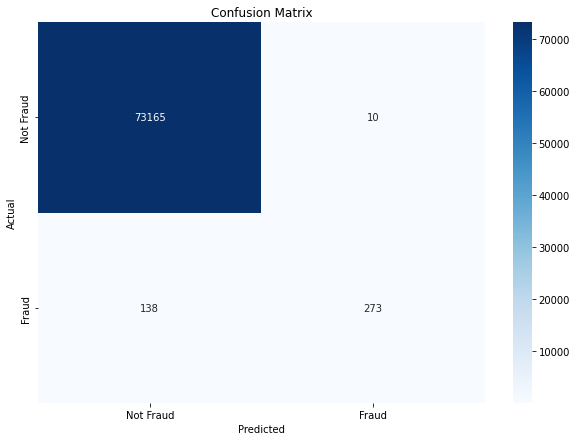

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(val_df['is_fraud'], val_df['predictions'])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()